# Importações

In [1]:
# Imports padrão
import os
import warnings
import pandas as pd
import joblib
import mlflow

# Configurações iniciais
warnings.filterwarnings("ignore", message="Protobuf gencode version")

# Imports locais (funções e constantes definidas no projeto)
from functions import (
    # Carregamento e preparação de dados
    load_datasets, prepare_daily_series, preprocess_price, build_group_map,
    expand_to_full_calendar, aggregate_group_daily, deseasonalize_spent,
    
    # Análise e visualização
    print_average_daily_points, analyze_seasonality, plot_raw_price_by_product,
    plot_window_correlation_by_product,
    
    # Engenharia de features
    compute_base_features, compute_rolling_targets,

    # Modelagem
    run_training_pipeline, avaliar_todos_modelos,

    # Alocação e previsão
    recursive_allocation_forecast, expand_group_alloc_to_clients,

    # Constantes
    MLFLOW_DIR, OUTPUT_PATH, DATA_PATH)

# Análise Exploratória de Dados

Iniciamos comparando as séries temporais de vendas (`historical_orders`) com os pontos de marketing (`marketing_points`). Identificamos que a correlação entre essas variáveis se torna mais evidente quando aplicamos médias móveis às séries, o que suaviza flutuações de curto prazo e destaca tendências mais amplas.

No entanto, as séries de vendas apresentam uma sazonalidade anual bastante pronunciada. Para representar de forma mais precisa a relação com os pontos de marketing, esse efeito sazonal foi removido, possibilitando uma análise de correlação mais robusta.

Após a dessazonalização, observamos que os produtos **0** e **1** apresentam correlações significativas com os pontos de marketing, variando entre **0.4 e 0.5**, com aumento consistente à medida que a janela da média móvel cresce. Já o produto **2** mostra uma correlação menor, com um pico por volta de **34 dias de janela**, seguido de uma redução conforme janelas maiores são utilizadas.

Ao analisarmos a evolução dos preços ao longo do tempo, verificamos que **não ocorreram variações substanciais**. Os preços permaneceram relativamente estáveis nos últimos anos, o que reduz a chance de confundirmos efeitos de preço com o impacto dos pontos de marketing.

In [2]:
historical_orders, marketing_points, price = load_datasets()

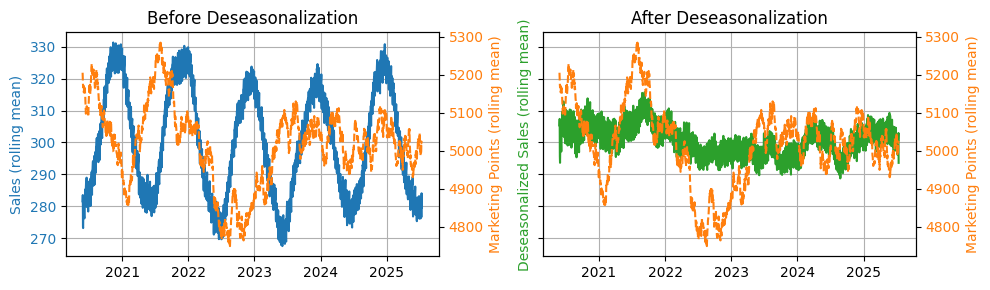

In [3]:
daily_quantity, daily_points = prepare_daily_series(historical_orders, marketing_points, date_col='date',
                                                    quantity_col='quantity', points_col='points')

analyze_seasonality(daily_quantity, daily_points, window=180, period=365)

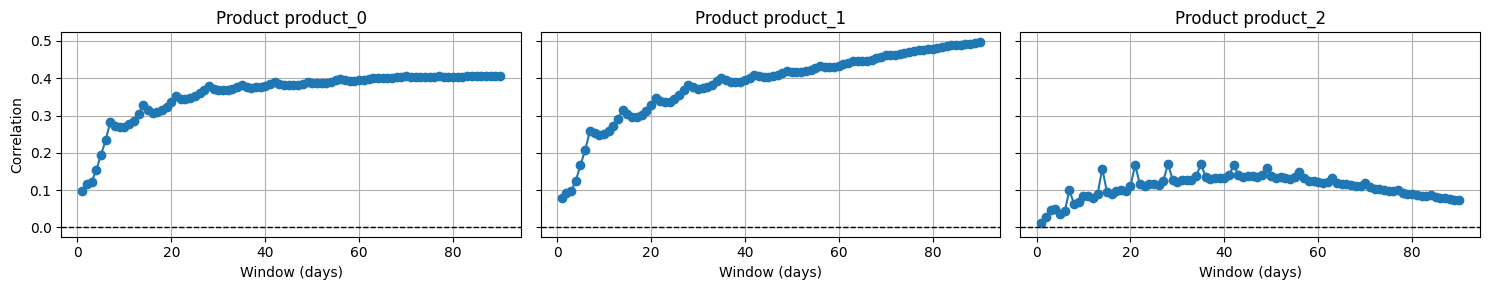

In [4]:
plot_window_correlation_by_product(historical_orders=historical_orders, marketing_points=marketing_points,
                                   seasonality_period=365, min_window=1, max_window=90)

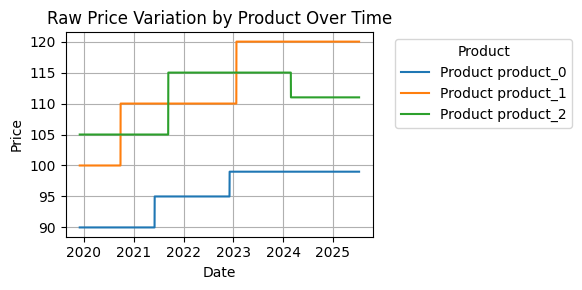

In [5]:
plot_raw_price_by_product(price)

In [6]:
average_daily = print_average_daily_points(marketing_points)
print(f"Average daily marketing points over the period: {average_daily:.2f}")

Average daily marketing points over the period: 5026.73


# Conclusão da análise exploratória e descrição da metodologia

### Modelamento do Comportamento dos Clientes e Alocação Ótima de Pontos

Identificamos que o impacto dos pontos de marketing sobre as vendas varia de acordo com o produto, sendo necessário analisar cada produto separadamente. Assim, optamos por **modelar o comportamento dos clientes com relação aos pontos de marketing recebidos por produto**.

A modelagem individual por cliente, no entanto, é inviável devido à **baixa frequência de registros por cliente**, o que impede o aprendizado adequado de seus padrões de resposta. Para contornar essa limitação, optamos por **agrupar os clientes em quatro grupos**, com base na **relação entre os pontos de marketing recebidos e a quantidade de compras realizadas**. Essa abordagem nos permite **diferenciar clientes mais influenciados pelo marketing daqueles menos sensíveis**, viabilizando um modelamento mais robusto.

Para mapear o comportamento de cada grupo de clientes, utilizamos uma **rede neural do tipo MLP (Multi-Layer Perceptron)**. O modelo é alimentado com **features derivadas das médias móveis das séries de marketing e vendas**, tais como:

- Pontos de marketing alocados no dia atual;
- Médias móveis de pontos de marketing até o dia atual;
- Quantidade de vendas do dia anterior;
- Médias móveis de vendas até o dia anterior.

O objetivo do modelo é **prever a quantidade de vendas do dia atual** e também as **médias móveis das vendas dos próximos dias**, permitindo identificar o impacto imediato e futuro dos pontos de marketing investidos hoje.

Com o comportamento aprendido para cada grupo de clientes, seguimos para a etapa de **otimização da receita**. Nessa fase, testamos diversas combinações possíveis de pontos de marketing (5000*) entre produtos e grupos, utilizando o modelo treinado para prever as vendas e calcular a receita correspondente. A **combinação que retorna a maior receita** é selecionada.

Após essa alocação ideal entre produtos e grupos, os pontos de marketing são **distribuídos de forma simples entre os clientes dentro de cada grupo**, já que **não há, por ora, padrões mais sofisticados identificáveis para otimização no nível individual**.

A proposta final do modelo é que ele **faça o planejamento da alocação de pontos para o dia atual**, utilizando as informações dos últimos 180 dias. No entanto, o mesmo modelo pode ser **usado de forma recursiva** para simular a evolução futura e **planejar vários dias à frente**, se necessário.

*OBS = 5000 pontos de marketing por dia é a média do dataset e foi adotada como fator limitante para a otimização. Porém, esse limite também pode ser otimizado.

# Preparação dos dados para modelar a resposta dos grupos de clientes às ações de marketing.

In [7]:
# Carregar os dados
historical_orders, marketing_points, price = load_datasets()

# Garantir que as colunas de data estejam no mesmo formato
historical_orders['date'] = pd.to_datetime(historical_orders['date'])
marketing_points['date'] = pd.to_datetime(marketing_points['date'])
price['date'] = pd.to_datetime(price['date'])

# Define o intervalo total de datas com base nos dados históricos
min_date = min(historical_orders["date"].min(), marketing_points["date"].min(), price["date"].min())
max_date = max(historical_orders["date"].max(), marketing_points["date"].max(), price["date"].max())

# Aplica o pré-processamento da tabela de preços
price = preprocess_price(price, min_date=min_date, max_date=max_date)

# Dessazonalizar o spend (gasto)
historical_orders = (
    historical_orders
    .merge(price, on=['product','date'], how='left')
    .assign(spend=lambda df: df.quantity * df.price)
)
historical_orders = deseasonalize_spent(
    historical_orders,
    product_col="product",
    date_col="date",
    value_col="spend",
    period=365,
    model="additive"
)

In [8]:
# Construir grupos de clientes
group_map = build_group_map(
    orders=historical_orders,
    points=marketing_points,
    n_groups=4
)

# Agregar vendas e pontos por product×group×dia
df_gp = aggregate_group_daily(
    orders=historical_orders,
    points=marketing_points,
    group_map=group_map
)

df_gp.to_parquet(os.path.join(DATA_PATH, 'df_gp.parquet'))

# Expandir calendário completo
df_full = expand_to_full_calendar(
    df_gp,
    start=historical_orders['date'].min(),
    end=historical_orders['date'].max()
)

# Calcular features base (lags e médias móveis de spent e points)
df_base = compute_base_features(
    df_full,
    windows=[180, 90, 60, 34, 28, 21, 14, 7])

# Gerar targets rolling sobre o spend
df_feat = compute_rolling_targets(
    df_base,
    horizon=14,
    window=180)

# Treinamento das redes neurais para modelar o comportamento dos grupos de clientes frente às ações de marketing.

In [9]:
os.makedirs(MLFLOW_DIR, exist_ok=True)

mlflow.set_tracking_uri(MLFLOW_DIR.as_uri())

experiment_name = "Desafio_MT2"

# Tenta criar o experimento, se já existir só pega o ID
try:
    experiment_id = mlflow.create_experiment(experiment_name)
except mlflow.exceptions.MlflowException:
    experiment = mlflow.get_experiment_by_name(experiment_name)
    experiment_id = experiment.experiment_id

As features (x_cols) incluem a alocação atual de recurso (points), médias móveis históricas de pontos (points_ma_) calculadas até o dia atual, e médias móveis históricas de gastos (spend_ma_) calculadas apenas até o dia anterior. Também inclui o gasto do dia imediatamente anterior (spend_lag1). Os alvos (y_cols) representam o gasto total do dia atual e as médias móveis de 180 dias dos gastos previstos para os próximos 14 dias, usados para modelar a resposta futura à alocação de pontos.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


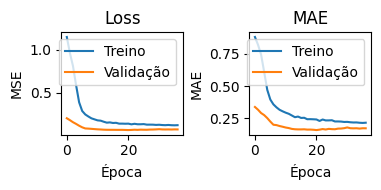

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


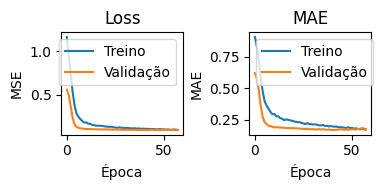

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


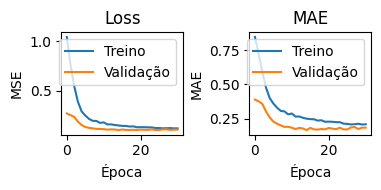

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


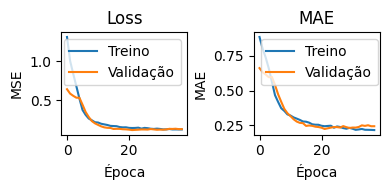

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


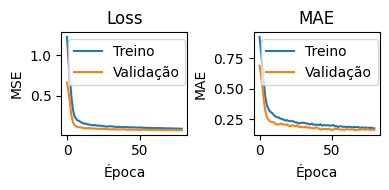

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


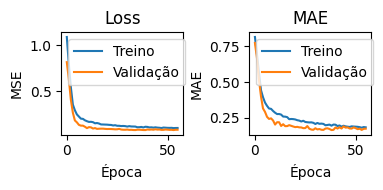

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


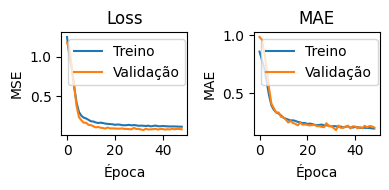

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


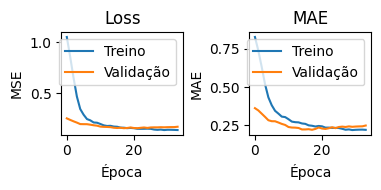

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


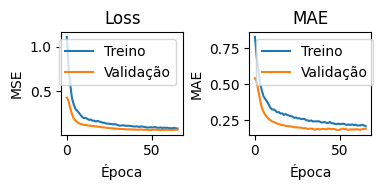

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


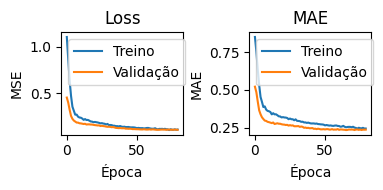

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


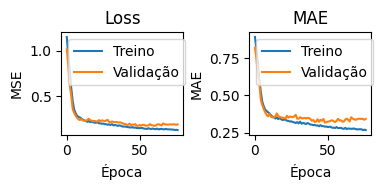

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


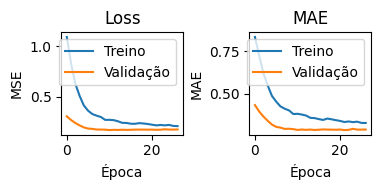

['c:\\Users\\engen\\OneDrive\\Área de Trabalho\\desafio_mt2\\mlruns\\mlp_models.pkl']

In [10]:
df_feat = df_feat.dropna().reset_index(drop=True)

# FEATURE E TARGETS
x_cols = [
    'points',
    'points_ma_7', 'points_ma_14', 'points_ma_21', 'points_ma_28',
    'points_ma_34', 'points_ma_60', 'points_ma_90', 'points_ma_180',
    'spend_ma_7', 'spend_ma_14', 'spend_ma_21', 'spend_ma_28',
    'spend_ma_34', 'spend_ma_60', 'spend_ma_90', 'spend_ma_180',
    'spend_lag1'
]

y_cols = [
    'total_spend', 'target_spend_ma180_tplus0',   'target_spend_ma180_tplus1',
    'target_spend_ma180_tplus2',  'target_spend_ma180_tplus3',   'target_spend_ma180_tplus4',
    'target_spend_ma180_tplus5',  'target_spend_ma180_tplus6',   'target_spend_ma180_tplus7',
    'target_spend_ma180_tplus8',  'target_spend_ma180_tplus9',   'target_spend_ma180_tplus10',
    'target_spend_ma180_tplus11', 'target_spend_ma180_tplus12',  'target_spend_ma180_tplus13'
]

mlp_models = run_training_pipeline(df_feat, x_cols, y_cols, experiment_id)
joblib.dump(mlp_models, os.path.join(MLFLOW_DIR, 'mlp_models.pkl'))

# Avaliando os modelos nos dados de teste

In [11]:
test_df = df_feat[df_feat['date'] >= '2025-01-01']
avaliacoes_df = avaliar_todos_modelos(test_df, mlp_models, x_cols, y_cols)
avaliacoes_df

,product,group_id,r2_mean,r2_total_spend,r2_target_spend_ma180_tplus0,r2_target_spend_ma180_tplus1,r2_target_spend_ma180_tplus2,r2_target_spend_ma180_tplus3,r2_target_spend_ma180_tplus4,r2_target_spend_ma180_tplus5,r2_target_spend_ma180_tplus6,r2_target_spend_ma180_tplus7,r2_target_spend_ma180_tplus8,r2_target_spend_ma180_tplus9,r2_target_spend_ma180_tplus10,r2_target_spend_ma180_tplus11,r2_target_spend_ma180_tplus12,r2_target_spend_ma180_tplus13
0,product_0,G1,0.710076,0.008826,0.727368,0.775021,0.695121,0.709396,0.693473,0.768111,0.793758,0.731904,0.762519,0.767405,0.769683,0.781782,0.828182,0.838590
1,product_0,G2,0.712061,-0.014059,0.818378,0.803888,0.795867,0.783964,0.773441,0.787110,0.796986,0.782018,0.738742,0.732287,0.715483,0.719278,0.718194,0.729339
2,product_0,G3,0.755323,0.004491,0.757060,0.657706,0.724004,0.787893,0.789423,0.786874,0.844989,0.841949,0.852389,0.860940,0.846349,0.833877,0.890425,0.851480
3,product_0,G4,0.287288,-0.013765,0.582420,0.442554,0.419185,0.490841,0.392881,0.280163,0.360962,0.324816,0.235821,0.242596,0.120627,0.169282,0.181672,0.079265
4,product_1,G1,0.492144,0.038199,0.748966,0.755985,0.739207,0.717534,0.678668,0.626518,0.602462,0.581294,0.452714,0.445994,0.358751,0.344751,0.167284,0.123831
5,product_1,G2,0.302877,-0.006148,0.289991,0.240365,0.444673,0.331728,0.359804,0.305933,0.398374,0.314685,0.331990,0.298302,0.337419,0.312625,0.261200,0.322205
6,product_1,G3,0.195180,-0.020340,0.422997,0.392727,0.409719,0.397212,0.062333,0.291318,0.270654,0.163491,0.195482,0.211198,0.130242,-0.027621,0.098129,-0.069841
7,product_1,G4,0.367398,-0.012397,0.749884,0.713442,0.632972,0.586491,0.513236,0.472968,0.421151,0.358693,0.227954,0.284573,0.391417,0.147230,-0.000464,0.023818
8,product_2,G1,0.762105,0.756461,0.851634,0.774917,0.768665,0.780769,0.779672,0.797218,0.840159,0.738934,0.671427,0.703052,0.697954,0.720896,0.731147,0.818674
9,product_2,G2,0.685696,0.673995,0.775936,0.718715,0.722386,0.708044,0.715676,0.735786,0.728932,0.669575,0.614807,0.654646,0.587487,0.649002,0.665781,0.664667


Os resultados do modelo mostram desempenho variado entre produtos e grupos. O R² médio geral indica boa capacidade explicativa para algumas combinações, especialmente para a previsão das médias móveis de gasto futuro, com valores frequentemente acima de 0.7. No entanto, a previsão do gasto total do dia atual apresenta valores baixos ou até negativos em vários casos, indicando que o modelo ainda tem espaço para melhorias nessa tarefa específica.

Essas limitações podem ser superadas com uma seleção mais adequada das features, explorando variáveis adicionais que capturem melhor a dinâmica do gasto diário. Além disso, a adoção de outros modelos, assim como o uso de ensembles, pode aumentar a robustez e precisão das previsões.

## O pipeline de modelagem de resposta funciona assim:

1. **Geração das Curvas de Resposta**  
   Para cada par `(produto, grupo)`, usamos o histórico dos últimos `lookback` dias agregados e, para uma faixa de alocações hipotéticas de pontos de marketing (`0 → B` em incrementos de `step`), nós:
   - Inserimos uma linha “hoje” com `points = x` e `total_spend = 0`.  
   - Recalculamos todas as features de lag e médias móveis.  
   - Utilizamos a MLP treinada para prever o gasto de hoje (`total_spend`).  
   - Registramos a previsão média de gasto para cada nível de pontos.  
   Isso produz uma “curva de resposta” mostrando **gasto esperado vs. pontos de marketing**.

2. **Inspeção Visual dos Efeitos Não Lineares**  
   Plotar essas curvas de resposta em pequenos gráficos (um por produto‐grupo) evidencia que:
   - A relação **não é puramente linear** — nem sempre mais pontos resultam em aumento proporcional de gasto.  
   - Retornos decrescentes ou até quedas podem ocorrer, indicando saturação ou efeito contraproducente.

3. **Alocação Ótima do Orçamento**  
   Em seguida, alimentamos todas as curvas de resposta em um otimizador estilo “knapsack” (`allocate_budget_dp`) que:
   - Recebe um orçamento diário total `B` de pontos.  
   - Encontra a combinação de alocações por grupo que maximiza a receita.

4. **Forecast Recursivo**  
   Para projetar múltiplos dias à frente, repetimos:
   - Aplicar a alocação ótima de hoje.  
   - Prever o gasto de amanhã.  
   - Adicionar essa previsão ao histórico.  
   - Repetir para o número de passos desejado.  
   Isso permite simular como uma sequência de alocações evolui o gasto dos clientes ao longo do tempo.


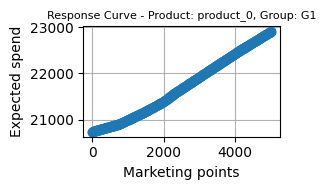

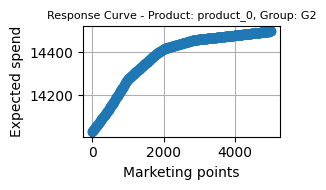

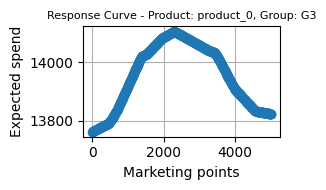

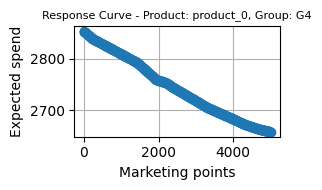

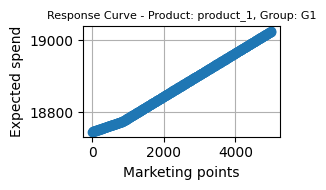

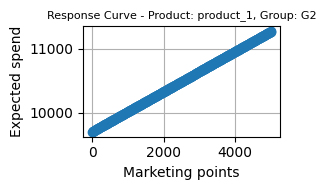

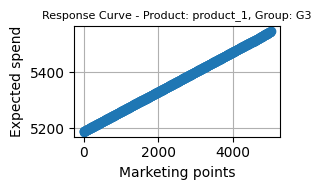

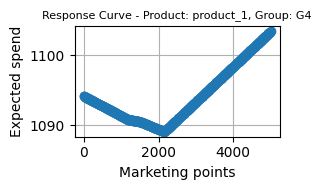

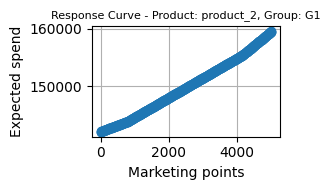

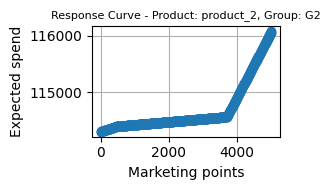

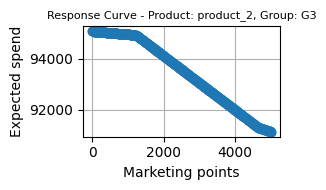

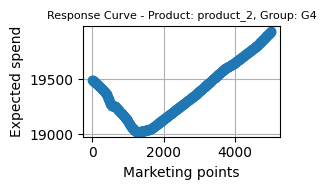

In [12]:
mlp_models = joblib.load(os.path.join(MLFLOW_DIR, 'mlp_models.pkl'))
df_gp = pd.read_parquet(os.path.join(DATA_PATH, 'df_gp.parquet'))

extended_df, alloc_schedule = recursive_allocation_forecast(
    df_gp, mlp_models, x_cols, y_cols,
    steps=1, B=5000, lookback=180, step=10,) #Steps são os dias a frente e step a resolução da alocação de pontos

# Alocando os pontos de marketing por cliente de cada grupo

In [13]:
client_alloc_df = expand_group_alloc_to_clients(alloc_schedule, group_map)
client_alloc_df

,date,product,client,points
0,2025-07-13,product_2,client_6,250
1,2025-07-13,product_2,client_35,310
2,2025-07-13,product_2,client_4,110
3,2025-07-13,product_2,client_76,60
4,2025-07-13,product_2,client_51,310
5,2025-07-13,product_2,client_85,510
6,2025-07-13,product_2,client_10,510
7,2025-07-13,product_2,client_47,310
8,2025-07-13,product_2,client_86,10
9,2025-07-13,product_2,client_0,100


In [14]:
# salva no arquivo solution.csv dentro de base_path
client_alloc_df.to_csv(OUTPUT_PATH, index=False)

print(f"Arquivo salvo em {OUTPUT_PATH}")

Arquivo salvo em c:\Users\engen\OneDrive\Área de Trabalho\desafio_mt2\solution.csv


**Justificativa da Abordagem e Lógica de Negócio**

A abordagem foca na otimização da alocação de pontos de marketing por grupos de clientes e produtos, segmentando o problema para melhor capturar comportamentos específicos e dinâmicas distintas dentro de cada grupo. Esse particionamento modular permite ajustar facilmente a composição dos grupos conforme novos dados e insights são incorporados, potencializando a eficácia das recomendações.

O modelo utiliza históricos de investimento em pontos de marketing e gastos dos clientes para prever o impacto desses pontos na receita futura, permitindo uma alocação estratégica que maximize o retorno esperado. A predição é feita em janelas diárias, mas o sistema suporta alocação para múltiplos dias à frente.

Entretanto, o ideal é que a alocação seja atualizada diariamente com as vendas reais do dia anterior, fornecendo ao modelo a informação mais recente e garantindo que as decisões reflitam a dinâmica atual do mercado. Essa atualização contínua melhora a precisão da previsão e a eficiência da alocação, tornando a recomendação adaptativa e responsiva às variações reais do comportamento do cliente.

Esta é uma versão inicial do pipeline, que pode ser aprimorada de diversas formas. A análise detalhada das features atuais, bem como a criação e incorporação de novas variáveis, pode revelar insights importantes sobre o comportamento dos clientes diante dos investimentos de marketing, elevando a qualidade do modelo e das recomendações futuras.
